# Prediction of article prices

Problem definition: Build an algorithm which predicts article prices based on product characteristerics.

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import numpy as np

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT * 
                    FROM public.tracking_staging 
                    WHERE date >= CURRENT_DATE - INTERVAL '90 days'
                    LIMIT 50000
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data = data[["size_title", "color1_id", "brand_title", "price_numeric", "status", "catalog_id"]]
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id
0,M / 38 / 10,4.0,,6,Muito bom,1071
1,M / 38 / 10,1.0,Camaïeu,3,Muito bom,221
2,M / 38 / 10,9.0,Pimkie,6,Muito bom,1839
3,,1.0,Bershka,3,Muito bom,20
4,S / 36 / 8,1.0,Jacqueline Riu,6,Muito bom,532
...,...,...,...,...,...,...
49995,12-18 meses / 80 cm,26.0,Zara,4,Muito bom,1537
49996,18-24 meses / 86 cm,26.0,Mango,3,Muito bom,1542
49997,S / 36 / 8,7.0,Levi's,8,Bom,196
49998,13 anos / 158 cm,1.0,La Halle,5,Bom,1880


## Dataframe inspection

Let's use df.info(), describe() and null count to check the properties of the dataframe.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   size_title     50000 non-null  object
 1   color1_id      43923 non-null  object
 2   brand_title    50000 non-null  object
 3   price_numeric  50000 non-null  int64 
 4   status         50000 non-null  object
 5   catalog_id     50000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [4]:
data.describe(include = 'object')

,size_title,color1_id,brand_title,status
count,50000,43923,50000,50000
unique,239,48,4352,5
top,,1.0,,Muito bom
freq,9299,12599,7924,26890


In [5]:
data.isnull().sum()

size_title          0
color1_id        6077
brand_title         0
price_numeric       0
status              0
catalog_id          0
dtype: int64

## Issues so far:

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?
## Approaches

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [6]:
# replacing color1_id with value 0
data["color1_id"] = data["color1_id"].fillna(value = 0)
data.isnull().sum()

size_title       0
color1_id        0
brand_title      0
price_numeric    0
status           0
catalog_id       0
dtype: int64

In [7]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id
0,M / 38 / 10,4.0,no_brand,6,Muito bom,1071
1,M / 38 / 10,1.0,Camaïeu,3,Muito bom,221
2,M / 38 / 10,9.0,Pimkie,6,Muito bom,1839
3,no_size,1.0,Bershka,3,Muito bom,20
4,S / 36 / 8,1.0,Jacqueline Riu,6,Muito bom,532
...,...,...,...,...,...,...
49995,12-18 meses / 80 cm,26.0,Zara,4,Muito bom,1537
49996,18-24 meses / 86 cm,26.0,Mango,3,Muito bom,1542
49997,S / 36 / 8,7.0,Levi's,8,Bom,196
49998,13 anos / 158 cm,1.0,La Halle,5,Bom,1880


## Taking a deeper look into size title

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [8]:
import plotly.express as px

# Assuming your DataFrame is called data
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

## Taking a deeper look into brand title

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [9]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to size titles

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [10]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 150].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['M / 38 / 10', 'no_size', 'S / 36 / 8', '36', 'L / 40 / 12',
       'XL / 42 / 14', '39', 'XS / 34 / 6', 'Tamanho único', 'M', 'XS',
       'L', '40', 'S', '37', 'XXS / 32 / 4', '4 anos / 104 cm',
       '10 anos / 140 cm', '3 anos / 98 cm', '11 anos / 146 cm',
       '12 anos / 152 cm', '14 anos / 164 cm', '6 anos / 116 cm',
       '5 anos / 110 cm', '9-12 meses / 74\xa0cm', '3-6 meses / 62\xa0cm',
       '6-9 meses / 68 cm', '8 anos / 128 cm', '41', '44', '43', 'XL',
       '18-24 meses / 86\xa0cm', '24-36 meses / 92 cm', 'XXL / 44 / 16',
       '42', '38', 'Até 1 mês / 50\xa0cm', '1-3 meses / 56\xa0cm',
       'XXXL / 46 / 18', 'XXL', 'Outro', '12-18 meses / 80\xa0cm', '45'],
      dtype=object)

In [11]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

In [12]:
# create is shoe label
data['is_shoe'] = data['size_title'].apply(lambda x: 1 if str(x).replace('.', '', 1).replace(',', '', 1).isdigit() else 0)
data

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14292\2113272068.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,size_title,color1_id,brand_title,price_numeric,status,catalog_id,is_shoe
0,M / 38 / 10,4.0,no_brand,6,Muito bom,1071,0
1,M / 38 / 10,1.0,Camaïeu,3,Muito bom,221,0
2,M / 38 / 10,9.0,Pimkie,6,Muito bom,1839,0
3,no_size,1.0,Bershka,3,Muito bom,20,0
4,S / 36 / 8,1.0,Jacqueline Riu,6,Muito bom,532,0
...,...,...,...,...,...,...,...
49994,24-36 meses / 92 cm,12.0,Zara,6,Novo com etiquetas,2079,0
49995,12-18 meses / 80 cm,26.0,Zara,4,Muito bom,1537,0
49996,18-24 meses / 86 cm,26.0,Mango,3,Muito bom,1542,0
49997,S / 36 / 8,7.0,Levi's,8,Bom,196,0


## Approaches to brand titles

- Remove size classes below a certain threshold

In [13]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 150].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['no_brand', 'Camaïeu', 'Pimkie', 'Bershka', 'Zara', 'Mango',
       'Cache Cache', 'Kiabi', 'Shein', 'Pull & Bear', 'Lacoste', 'Nike',
       'H&M', 'Primark', 'ONLY', 'Vintage', 'Local', 'Stradivarius',
       'Decathlon', 'Donna', 'Puma', 'adidas', "Levi's", 'Ralph Lauren',
       'Tommy Hilfiger', 'Inconnu', 'Gémo', 'Orchestra', 'Jennyfer',
       'Disney', 'Scarpe'], dtype=object)

In [14]:
from sklearn.model_selection import train_test_split
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["is_shoe"] = data["is_shoe"].astype("category")
data.info()


C:\Users\Miguel\AppData\Local\Temp\ipykernel_14292\3267077543.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14292\3267077543.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14292\3267077543.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

<class 'pandas.core.frame.DataFrame'>
Index: 21684 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   size_title     21684 non-null  category
 1   color1_id      21684 non-null  category
 2   brand_title    21684 non-null  category
 3   price_numeric  21684 non-null  int64   
 4   status         21684 non-null  category
 5   catalog_id     21684 non-null  category
 6   is_shoe        21684 non-null  category
dtypes: category(6), int64(1)
memory usage: 512.2 KB


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17347 entries, 14257 to 35984
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   size_title   17347 non-null  category
 1   color1_id    17347 non-null  category
 2   brand_title  17347 non-null  category
 3   status       17347 non-null  category
 4   catalog_id   17347 non-null  category
 5   is_shoe      17347 non-null  category
dtypes: category(6)
memory usage: 279.2 KB


In [16]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

d_train=lgb.Dataset(X_train, label=y_train)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 500,
    'max_depth': 16,
    'num_leaves': 2**5,
    'learning_rate': 0.01,
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

y_pred = clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int32)
errors = y_pred - y_test


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 17347, number of used features: 6
[LightGBM] [Info] Start training from score 11.575777
Mean Squared Error: 219.63154254092692


In [17]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results

,Prediction,Test
0,10,18
1,13,6
2,6,10
3,4,1
4,3,2
...,...,...
4332,3,3
4333,6,2
4334,20,10
4335,3,4


Text(0.5, 1.0, 'Actual vs. Predicted')

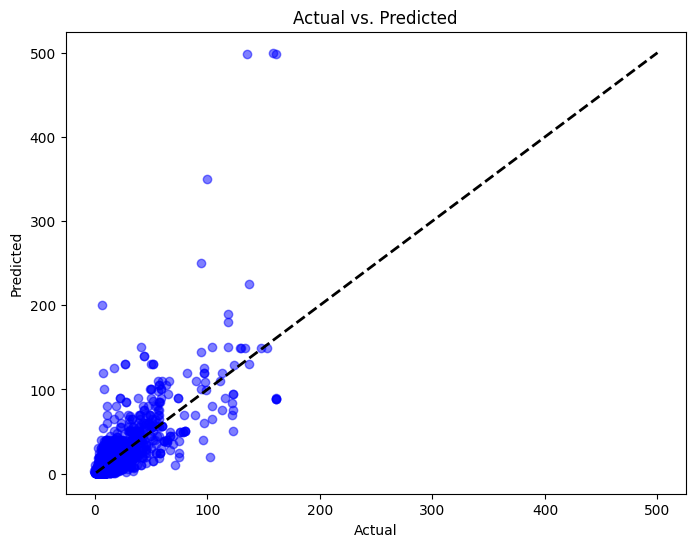

In [18]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

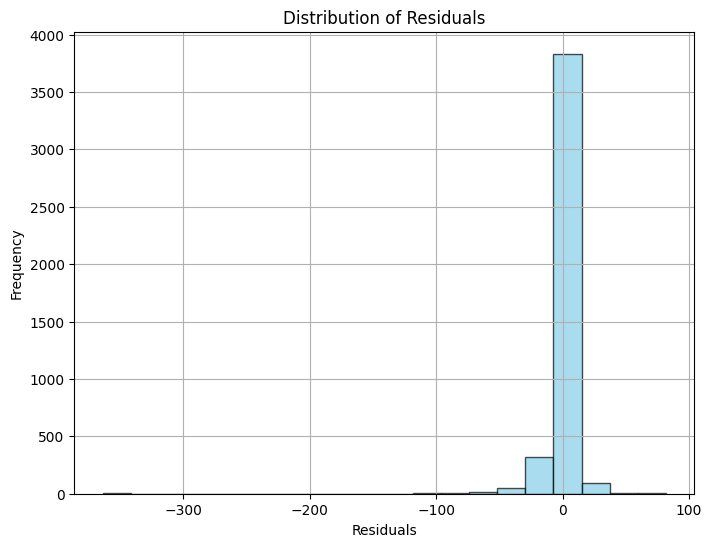

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

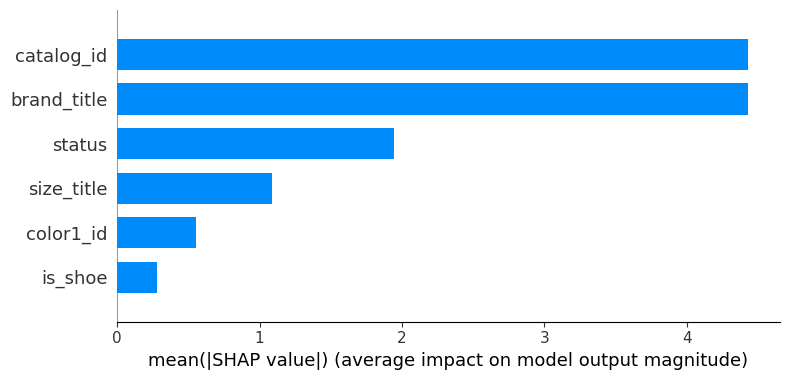

In [20]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

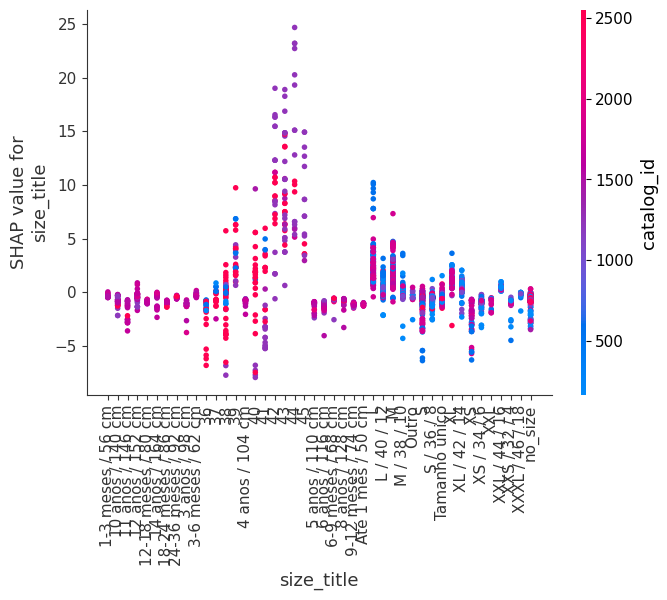

In [21]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")

In [22]:
import seaborn as sns

results["residues"] = results["Prediction"]-results["Test"]
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='residuals', data=results)
plt.title('Residuals by Label')
plt.xlabel('Label')
plt.ylabel('Residuals')
plt.grid(True)

KeyError: 'y_pred'